In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ndcg_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM

from imblearn.ensemble import RUSBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss

from collections import Counter

from xgboost import XGBClassifier 

import matplotlib.pyplot as plt



In [2]:
data = pd.read_csv('uscecchini28.csv')
data.head()

,fyear,gvkey,sich,insbnk,understatement,option,p_aaer,new_p_aaer,misstate,act,...,soft_assets,ch_cs,ch_cm,ch_roa,issue,bm,dpi,reoa,EBIT,ch_fcf
0,1990,1009,3460.0,0,0,0,NaN,NaN,0,10.047,...,0.312448,0.095082,0.082631,-0.019761,1,0.413170,0.873555,0.167620,0.161961,-0.042140
1,1990,1011,4841.0,0,0,0,NaN,NaN,0,1.247,...,0.315904,0.188832,-0.211389,-0.117832,1,0.157887,0.745139,-0.428957,-0.157888,0.100228
2,1990,1017,3812.0,0,0,0,NaN,NaN,0,55.040,...,0.605342,0.097551,-0.105780,0.091206,1,2.231337,1.015131,0.394768,0.063681,0.066348
3,1990,1021,3861.0,0,0,0,NaN,NaN,0,24.684,...,0.793068,-0.005725,-0.249704,0.017545,1,1.043582,1.026261,0.094822,0.088347,-0.017358
4,1990,1028,7385.0,0,0,0,NaN,NaN,0,17.325,...,0.869182,-0.231536,-1.674893,-0.466667,0,-1.602508,0.598443,-0.942379,-0.700821,0.130349


0    145081
1       964
Name: misstate, dtype: int64
Not Fraud:  0.9933992947379232 %
Fraud:  0.006600705262076757 %


Text(0.5, 1.0, 'Fraud')

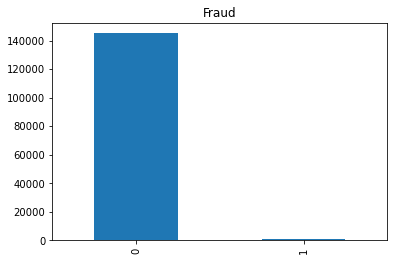

In [80]:
print(data.misstate.value_counts())
fraud = data.misstate.value_counts()[1]
not_fraud = data.misstate.value_counts()[0]
total = fraud + not_fraud
print('Not Fraud: ',not_fraud/total,'%')
print('Fraud: ',fraud/total,'%')                 
data['misstate'].value_counts().plot(kind = 'bar').set_title('Fraud')

# SCALER & SPLIT DATA

In [3]:
data.rename(columns = {'misstate':'fraud'}, inplace = True)
col_names = ['act','ap','ceq','che','cogs','csho','dlc','dltis','dltt','dp','ib', 'invt','ivao','ivst','lct','lt','ni','ppegt','pstk','re','rect','sale','sstk','txp','txt','xint','fraud'] # Folow author
col_names_importances = ['act','ap','at','ceq','che','cogs','csho','dlc','dltis','dltt','dp','ib','invt','ivao','ivst','lct','lt','ni','ppegt','pstk','re','rect','sale','sstk','txp','txt','xint','fraud'] # accept with scores >=0.02
data = data[data['fyear'] <= 2005]
features = data[col_names_importances]
# scaler = MinMaxScaler()  
# data[col_names] = scaler.fit_transform(features.values)
# data[col_names] = scaler.transform(data[col_names])

=> Ta thấy rằng dùng kỹ thuật lấy features importance với thuật toán XGBoosting ngưỡng 0.02 cũng nhận kết quả là các biến hoàn toàn giống như tác giả đã sử dụng 

In [5]:
X = features.drop(['fraud'], axis = 1)
y = features['fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

# RESAMPLING

# A. RANDOM - OVERSAMPLING

In [43]:
print(Counter(y_train))
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train.to_numpy(), y_train.to_numpy())
print(Counter(y_over))

Counter({0: 75861, 1: 613})
Counter({0: 75861, 1: 75861})


# B. RANDOM - UNDERSAMPLING

In [13]:
print(Counter(y_train))
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X_train.to_numpy(), y_train.to_numpy())
print(Counter(y_under))

Counter({0: 75861, 1: 613})
Counter({0: 613, 1: 613})


# C. RANDOM - COMBINING

In [5]:
print(Counter(y_train))

oversample = RandomOverSampler(sampling_strategy=0.1)
X_combine, y_combine = oversample.fit_resample(X_train.to_numpy(), y_train.to_numpy())

undersample = RandomUnderSampler(sampling_strategy=0.5)
X_combine, y_combine = undersample.fit_resample(X_combine, y_combine)
print(Counter(y_combine))

Counter({0: 75861, 1: 613})
Counter({0: 15172, 1: 7586})


# D. Under-sampling: Tomek links

In [73]:
print(Counter(y_train))
tomek_link =  TomekLinks(sampling_strategy='majority')
X_tomek, y_tomek = tomek_link.fit_resample(X_train, y_train)
print(Counter(y_tomek))


Counter({0: 75861, 1: 613})
Counter({0: 75734, 1: 613})


Counter({0: 75734, 1: 613})


# E. SMOTE

In [47]:
print(Counter(y_train))
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print(Counter(y_smote))

Counter({0: 75861, 1: 613})
Counter({0: 75861, 1: 75861})


# F. NearMiss

In [57]:
print(Counter(y_train))
nearmiss = NearMiss()
X_nearmiss, y_nearmiss = nearmiss.fit_resample(X_train, y_train)
print(Counter(y_nearmiss))

Counter({0: 75861, 1: 613})
Counter({0: 613, 1: 613})


# RUSBOOST

In [157]:
rus = RUSBoostClassifier(random_state=0)
rus.fit(X_combine, y_combine)
pred_rus = rus.predict(X_test)    

In [158]:
confusion_matrix(y_test, pred_rus)
roc_auc_score(y_test, pred_rus)


0.678203911645316

# LOGISTIC REGRESSION

In [22]:
logit = LogisticRegression(solver='liblinear', random_state=0)
logit.fit(X_combine, y_combine)
pred_logit = logit.predict(X_test)


In [23]:
confusion_matrix(y_test, pred_logit)
roc_auc_score(y_test, pred_logit)

1.0

# ADABOOSTING

In [9]:
ada = AdaBoostClassifier()
ada.fit(X_combine, y_combine)
pred_ada = ada.predict(X_test)

In [10]:
confusion_matrix(y_test, pred_ada)
roc_auc_score(y_test, pred_ada)

0.6362928989403764

# XGBOSSTING

In [11]:
xgb = XGBClassifier() 
xgb.fit(X_combine, y_combine)



[11:32:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
importance = xgb.feature_importances_
k=0
importances = []
for i in importance:
    if (i>=0.02):
        print(i, k)
        importances.append(i)
        k+=1
    k+=1
len(importances)

0.04325211 0
0.032288447 2
0.03292742 4
0.04622934 6
0.029663896 8
0.034305625 10
0.03304892 12
0.030203538 14
0.025361199 16
0.031149732 18
0.037068937 20
0.020291155 22
0.040094495 24
0.031477083 26
0.040478036 28
0.033826042 30
0.035891358 32
0.030313099 34
0.052214544 36
0.027404282 38
0.03527695 40
0.049117174 42
0.034611836 44
0.09429651 46
0.0382003 48
0.029221945 50
0.031785943 52


27

In [13]:
for col,score in zip(X_train.columns,importances):
    print(col,score)

act 0.04325211
ap 0.032288447
at 0.03292742
ceq 0.04622934
che 0.029663896
cogs 0.034305625
csho 0.03304892
dlc 0.030203538
dltis 0.025361199
dltt 0.031149732
dp 0.037068937
ib 0.020291155
invt 0.040094495
ivao 0.031477083
ivst 0.040478036
lct 0.033826042
lt 0.035891358
ni 0.030313099
ppegt 0.052214544
pstk 0.027404282
re 0.03527695
rect 0.049117174
sale 0.034611836
sstk 0.09429651
txp 0.0382003
txt 0.029221945
xint 0.031785943


Feature: 0, Score: 0.04325
Feature: 1, Score: 0.03229
Feature: 2, Score: 0.03293
Feature: 3, Score: 0.04623
Feature: 4, Score: 0.02966
Feature: 5, Score: 0.03431
Feature: 6, Score: 0.03305
Feature: 7, Score: 0.03020
Feature: 8, Score: 0.02536
Feature: 9, Score: 0.03115
Feature: 10, Score: 0.03707
Feature: 11, Score: 0.02029
Feature: 12, Score: 0.04009
Feature: 13, Score: 0.03148
Feature: 14, Score: 0.04048
Feature: 15, Score: 0.03383
Feature: 16, Score: 0.03589
Feature: 17, Score: 0.03031
Feature: 18, Score: 0.05221
Feature: 19, Score: 0.02740
Feature: 20, Score: 0.03528
Feature: 21, Score: 0.04912
Feature: 22, Score: 0.03461
Feature: 23, Score: 0.09430
Feature: 24, Score: 0.03820
Feature: 25, Score: 0.02922
Feature: 26, Score: 0.03179


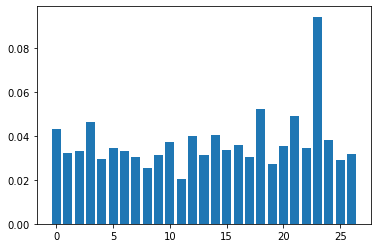

In [14]:

for i,v in enumerate(importance):
    print("Feature: %d, Score: %.5f" % (i, v))
plt.bar([x for x in range(len(importances))], importances)
plt.show()

DO VIỆC RESAMPLING DỰA TRÊN RANDOM NÊN KẾT QUẢ CÓ THỂ SẼ KHÁC NHAU

=> TA SẼ LẦN LƯỢT THỬ 20 LẦN KẾT HỢP VỚI K-CROSS VALIDATION ĐỂ LỰA CHỌN RA BỘ RESAMPLING TỐI ƯU NHẤT. LẤY AUC LÀM THƯỚC ĐO CHÍNH 

# COMBINE K-CROSS VALIDATION VS RESAMPLING

In [27]:
importances

[0.04325211,
 0.032288447,
 0.03292742,
 0.04622934,
 0.029663896,
 0.034305625,
 0.03304892,
 0.030203538,
 0.025361199,
 0.031149732,
 0.037068937,
 0.020291155,
 0.040094495,
 0.031477083,
 0.040478036,
 0.033826042,
 0.035891358,
 0.030313099,
 0.052214544,
 0.027404282,
 0.03527695,
 0.049117174,
 0.034611836,
 0.09429651,
 0.0382003,
 0.029221945,
 0.031785943]

In [6]:
score = {}
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
for i in range(1,20):
    oversample = RandomOverSampler(sampling_strategy=0.1)
    X_combine, y_combine = oversample.fit_resample(X_train.to_numpy(), y_train.to_numpy())
    undersample = RandomUnderSampler(sampling_strategy=0.5)
    X_combine, y_combine = undersample.fit_resample(X_combine, y_combine)

    rus = RUSBoostClassifier(random_state=0)
    cross_valid = cross_val_score(rus, X_combine, y_combine, cv = kfold, scoring= 'roc_auc').mean()

    score[cross_valid] = X_combine, y_combine


In [7]:
m_score = [(key, value) for key, value in score.items()]
optimal_combine = max(m_score)[1]

In [8]:
russ = RUSBoostClassifier(random_state=0)
russ.fit(optimal_combine[0], optimal_combine[1])
pred_russ = russ.predict(X_test)    

confusion_matrix(y_test, pred_russ)
roc_auc_score(y_test, pred_russ)
 

0.6771901523538406

# ONECLASS  SVM - NOVELTY DETECTION

In [14]:
%%time
train, test = train_test_split(features, test_size = 0.2)
train_normal = train[train.fraud == 0]
train_outlier = train[train.fraud == 1]
outlier_pop = len(train_outlier) / len(train_normal)
SVM = OneClassSVM(kernel='rbf', nu=outlier_pop, gamma = 0.000001)
SVM.fit(train_normal.drop(["fraud"], axis = 1))


CPU times: user 7.62 s, sys: 124 ms, total: 7.74 s
Wall time: 7.74 s


OneClassSVM(gamma=1e-06, nu=1e-05)

In [15]:
pred_svm = SVM.predict(test.drop(['fraud'], axis=1))
confusion_matrix(test.fraud.map({0:1, 1:-1}), pred_svm)
roc_auc_score(test.fraud.map({0:1, 1:-1}), pred_svm)

0.5